### Imports

In [19]:
import hashlib
import os
import random
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Utils

In [2]:
def random_salt(length:int = 10):
    """
    Function that generates a random salt
    """
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))


def hash(string, salt:str = 'salt'):
    """
    Function that hashes a string. You can controll randomness with a salt
    """
    salt_hash = hashlib.sha256(salt.encode('utf-8')).hexdigest()
    string_hash = hashlib.sha256(string.encode('utf-8')).hexdigest()
    return int(salt_hash, 16) ^ int(string_hash, 16)

In [3]:
SEED = 111

random.seed(SEED)
np.random.seed(SEED)

In [4]:
SPLIT_SALT = random_salt()
TRAINING_SALT = random_salt()

print(f'SPLIT_SALT: {SPLIT_SALT}')
print(f'TRAINING_SALT: {TRAINING_SALT}')

SPLIT_SALT: Zn6EyMkmAo
TRAINING_SALT: PzxrnS3vXt


### Data analysis

In [5]:
dataset = pd.read_json('../data/dataset_2weeks.jsonl', lines=True)

#### What is distribution of changes made by users, bots and no bots

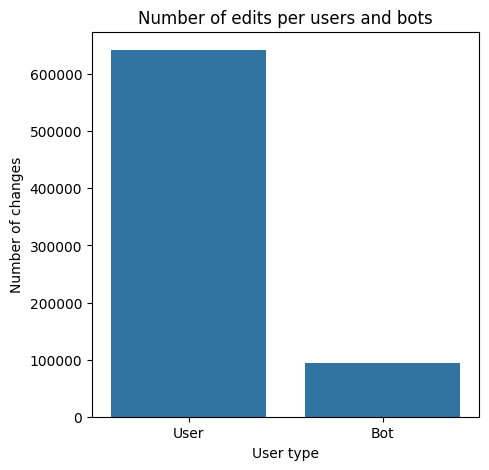

In [76]:
edits_df = dataset.groupby('bot').count().max(axis=1)
edits_df.index = edits_df.index.map(lambda x: 'Bot' if x else 'User')

sns.barplot(x=edits_df.index, y=edits_df.values)
plt.title('Number of edits per users and bots')
plt.xlabel('User type')
plt.ylabel('Number of changes')

fig = plt.gcf()
fig.set_size_inches(5, 5)

#### When the edits were made

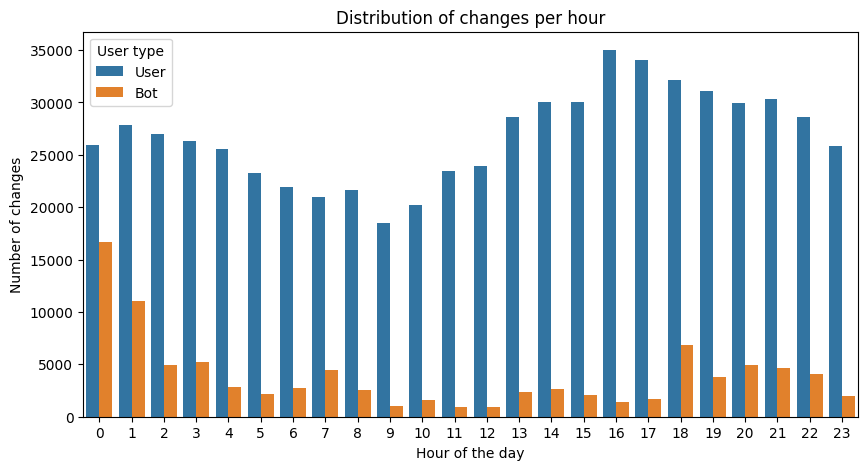

In [74]:
dataset['hour'] = dataset['timestamp'].map(lambda x: x.hour)

edits_per_hour_df = dataset.groupby(['bot', 'hour']).count().max(axis=1)
edits_per_hour_df.name = 'value'
edits_per_hour_df = edits_per_hour_df.reset_index()
edits_per_hour_df['bot'] = edits_per_hour_df['bot'].map(lambda x: 'Bot' if x else 'User')

sns.barplot(x='hour', y='value', hue='bot', data=edits_per_hour_df)
plt.xlabel('Hour of the day')
plt.ylabel('Number of changes')
plt.legend(title='User type')

plt.title('Distribution of changes per hour')

fig = plt.gcf()
fig.set_size_inches(10, 5)

### How fast changes are made

In [263]:
dataset = dataset.sort_values(by=['user', 'timestamp'])

dataset['time_delta'] = dataset.groupby('user')['timestamp'].diff()
user_time_delta_data = dataset[~dataset['time_delta'].isna()]

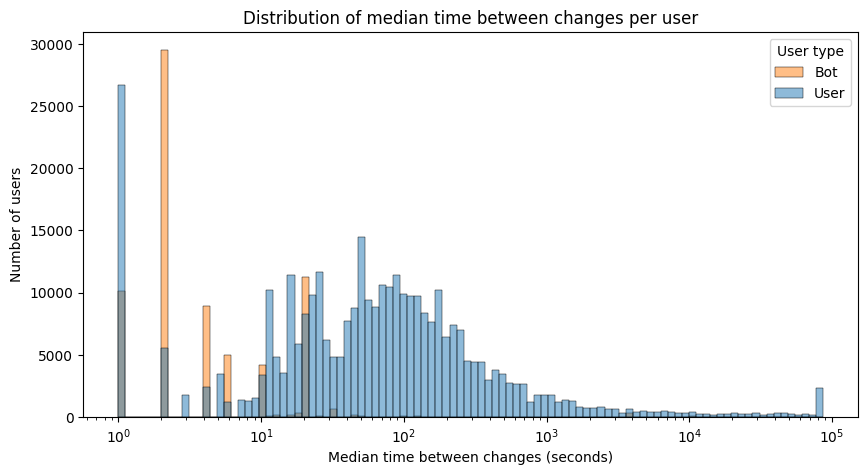

In [272]:
users_time_delta = pd.merge(
    user_time_delta_data.groupby('user')['time_delta'].median(),
    user_time_delta_data.set_index('user')['bot'],
    left_index=True,
    right_index=True
)
users_time_delta['time_delta'] = users_time_delta['time_delta'].astype('timedelta64[s]').astype(int)
users_time_delta['bot'] = users_time_delta['bot'].apply(lambda x: 'Bot' if x else 'User')
users_time_delta.loc[users_time_delta['time_delta'] > 86400, 'time_delta'] = 86400

ax = sns.histplot(data=users_time_delta, x='time_delta', hue='bot', bins=100, log_scale=True)

plt.title('Distribution of median time between changes per user')
plt.ylabel('Number of users')
plt.xlabel('Median time between changes (seconds)')
plt.legend(['Bot', 'User'], title='User type')

fig = plt.gcf()
fig.set_size_inches(10, 5)

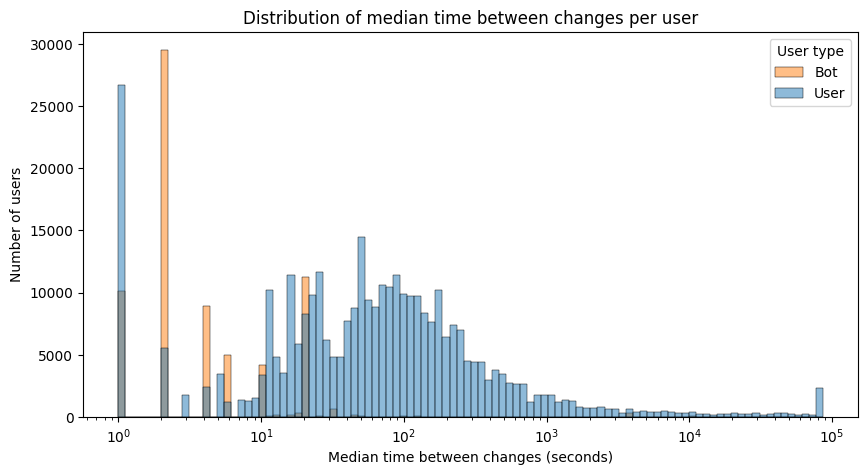